In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
np.random.seed(42)

In [3]:
categories = pd.read_csv('D:\EPAM\epam_mentorship\data\item_categories.csv')
items = pd.read_csv('D:\EPAM\epam_mentorship\data\items.csv')
shops = pd.read_csv('D:\EPAM\epam_mentorship\data\shops.csv')
sales = pd.read_csv('D:\EPAM\epam_mentorship\data\sales_train.csv')

### Checking NaN

In [4]:
shops.isna().sum(), items.isna().sum(), categories.isna().sum(), sales.isna().sum()

(shop_name    0
 shop_id      0
 dtype: int64,
 item_name           0
 item_id             0
 item_category_id    0
 dtype: int64,
 item_category_name    0
 item_category_id      0
 dtype: int64,
 date              0
 date_block_num    0
 shop_id           0
 item_id           0
 item_price        0
 item_cnt_day      0
 dtype: int64)

There are no NaN values

## Check common sense

In [5]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


The fact that item_cnt_day has the type float is kind of suspicios. It might be a sign of existing outliers

In [7]:
sales[sales.item_cnt_day != round(sales.item_cnt_day)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


There are no float values so let's transform float -> int

In [8]:
sales.item_cnt_day = sales.item_cnt_day.astype(int)

In [10]:
sales.describe(percentiles=[.25, .5, .75, .95]).drop(['shop_id', 'item_id'], axis = 1)

,date_block_num,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,8.908532e+02,1.242641e+00
std,9.422988e+00,1.729800e+03,2.618834e+00
min,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.990000e+02,1.000000e+00
75%,2.300000e+01,9.990000e+02,1.000000e+00
95%,3.100000e+01,2.690000e+03,2.000000e+00
max,3.300000e+01,3.079800e+05,2.169000e+03


Noticing some suspicios numbers in 'min' row

In [11]:
sales[sales.item_price <= 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1


In [12]:
len(sales[sales.item_cnt_day < 0])

7356

There are some incorrect values in 'item_price' and 'item_cnt_day'. As a solution we can erase all the outliers or make the negative count positive assuming the minus appeard just by mistake

# Fill missing months with 0


In [28]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1
1,03.01.2013,0,25,2552,899.00,1
2,05.01.2013,0,25,2552,899.00,-1
3,06.01.2013,0,25,2554,1709.05,1
4,15.01.2013,0,25,2555,1099.00,1


In [29]:
month_count_item = pd.DataFrame(sales.groupby(['item_id','shop_id', 'date_block_num'])['item_cnt_day'].sum()).reset_index(level = [0,1,2])
month_count_item.columns = ['item_id', 'shop_id', 'date_block_num', 'item_cnt_month']
month_count_item.head(10)                                                                                                                         

,item_id,shop_id,date_block_num,item_cnt_month
0,0,54,20,1
1,1,55,15,2
2,1,55,18,1
3,1,55,19,1
4,1,55,20,1
5,1,55,21,1
6,2,54,19,1
7,2,54,22,1
8,3,54,18,1
9,3,54,19,1


In [31]:
len(month_count_item)

1609124

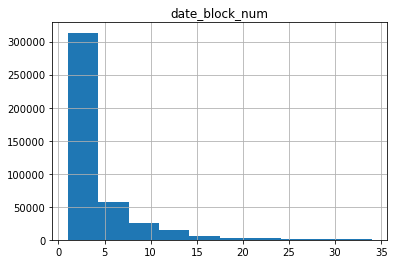

In [32]:
item_month = pd.DataFrame(month_count_item.groupby(['item_id', 'shop_id'])['date_block_num'].count())
item_month.hist()
plt.show()

In [33]:
it_index = []
sh_index = []
sh_len = len(shops)
date = []
for i in range(len(items)):
    it_index += [i]*(34 * sh_len)
    sh_index += list(range(sh_len))* 34
    date += list(range(34)) * sh_len

In [32]:
len(it_index), len(sh_index), len(date)

(45226800, 45226800, 45226800)

In [34]:
temp = pd.DataFrame({
    'item_id' : it_index,
    'shop_id': sh_index,
    'date_block_num' : date
})

KeyboardInterrupt: 

In [34]:
temp.head()

,item_id,shop_id,date_block_num
0,0,0,0
1,0,1,1
2,0,2,2
3,0,3,3
4,0,4,4


In [41]:
full_record_month = pd.merge(temp, month_count_item, how = 'left', on = ['item_id','shop_id', 'date_block_num'] )

In [46]:
full_record_month = full_record_month.fillna(0)

In [47]:
full_record_month.sample(10)

,item_id,shop_id,date_block_num,item_cnt_month
14382386,7050,26,12,0.0
36591535,17937,55,21,0.0
22353501,10957,21,31,0.0
32051236,15711,16,14,0.0
34773706,17045,46,2,0.0
37027659,18150,39,27,0.0
38887822,19062,22,16,0.0
9359899,4588,19,5,0.0
37186419,18228,39,7,0.0
19147209,9385,9,7,0.0


# Month check

In [14]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1
1,03.01.2013,0,25,2552,899.00,1
2,05.01.2013,0,25,2552,899.00,-1
3,06.01.2013,0,25,2554,1709.05,1
4,15.01.2013,0,25,2555,1099.00,1


In [15]:
month_count_item = pd.DataFrame(sales.groupby(['item_id', 'date_block_num'])['item_cnt_day'].sum()).reset_index(level = [0,1])

In [16]:
month_count_item.columns = ['item_id', 'date_block_num', 'item_cnt_month']

In [17]:
month_count_item

,item_id,date_block_num,item_cnt_month
0,0,20,1
1,1,15,2
2,1,18,1
3,1,19,1
4,1,20,1
...,...,...,...
233907,22168,0,2
233908,22168,1,2
233909,22168,2,1
233910,22168,8,1


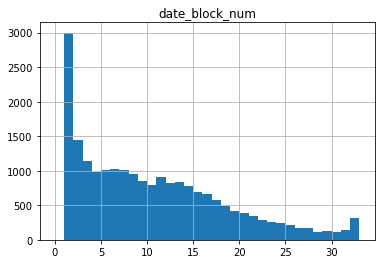

In [18]:
item_month = pd.DataFrame(month_count_item.groupby('item_id')['date_block_num'].count())
item_month.hist(bins = list(range(34)))
plt.show()

In [19]:
len(item_month), len(items)

(21807, 22170)

In [20]:
item_month.columns = ['month_count']
item_month.reset_index(level = [0])
item_month.sample(3)

,month_count
item_id,
3542,13
2699,6
17842,4


In [ ]:
temp  = pd.merge(items, item_month, how = 'left', on = 'item_id')
item_month = temp.fillna(0)

363 items were not sold at all

# Shops

In [21]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [22]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


 It looks like the first word is the name of the city. Let's extract city name from shop name and see if it can help.

In [23]:
shops['city'] = [x.split(' ')[0] for x in shops.shop_name]

In [24]:
shops.sample(5)

,shop_name,shop_id,city
6,"Воронеж (Плехановская, 13)",6,Воронеж
28,"Москва ТЦ ""МЕГА Теплый Стан"" II",28,Москва
33,"Мытищи ТРК ""XL-3""",33,Мытищи
59,"Ярославль ТЦ ""Альтаир""",59,Ярославль
36,"Новосибирск ТРЦ ""Галерея Новосибирск""",36,Новосибирск


We see duplicates at indexes 0-58, 1-59 

In [25]:
shops.iloc[0,2] = 'Якутск'
shops.iloc[1,2] = 'Якутск'
shops.iloc[0,0] = shops.iloc[0,0][1:]
shops.iloc[1,0] = shops.iloc[1,0][1:]
shops.head()

,shop_name,shop_id,city
0,"Якутск Орджоникидзе, 56 фран",0,Якутск
1,"Якутск ТЦ ""Центральный"" фран",1,Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [26]:
cities = pd.unique(shops['city'])
cities, len(cities)

(array(['Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
        'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
        'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
        'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
        'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
        'Ярославль'], dtype=object),
 31)

We see that there are "Интернет-магазин", "Цифровой", "Выездная" which are obviously not cities. Let's leave it the way it is for now. Maybe it will not be a problem

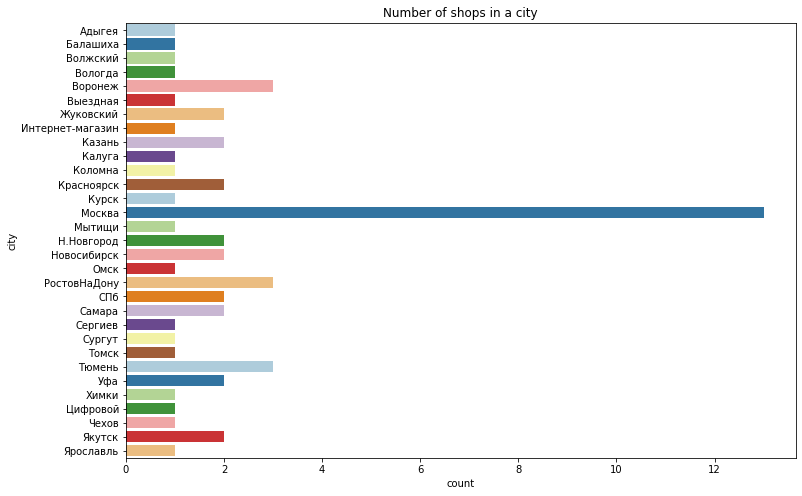

In [27]:
plt.figure(figsize=(12,8))
sns.countplot(y="city", data=shops.iloc[2:], palette = 'Paired')
plt.title('Number of shops in a city')
plt.show()

It looks like Moscow has more shops than any other city

# Categories

In [41]:
categories.sample(8)

,item_category_name,item_category_id,cat,sub_cat
73,Программы - 1С:Предприятие 8,73,Программы,1С:Предприятие 8
0,PC - Гарнитуры/Наушники,0,PC,Гарнитуры/Наушники
58,Музыка - Винил,58,Музыка,Винил
22,Игры - PSVita,22,Игры,PSVita
12,Игровые консоли - PS4,12,Игровые консоли,PS4
70,Подарки - Сувениры (в навеску),70,Подарки,Сувениры
10,Игровые консоли - PS2,10,Игровые консоли,PS2
18,Игры - PS2,18,Игры,PS2


In [29]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [30]:
len(pd.unique(categories['item_category_name']))

84

All the categories are unique. But there are a lot of them. If we look at the structure we'll see that most of the categories follow the pattern '1 - 2' where 2 is additional category

Let's extract first key words (before '-') and get rid of the words in braces as they also represent additional information which may be redundant to the model

In [14]:
categories['cat'] = [x.split('-')[0].strip().split('(')[0].strip() for x in categories['item_category_name'] ]
categories['sub_cat'] = categories["item_category_name"].str.split(" - ").str.get(1).str.strip().fillna("none")
categories['sub_cat'] = categories['sub_cat'].str.split('(').str.get(0).str.strip()

In [40]:
pd.unique(categories.sub_cat)

array(['Гарнитуры/Наушники', 'PS2', 'PS3', 'PS4', 'PSP', 'PSVita',
       'XBOX 360', 'XBOX ONE', 'none', 'Прочие', 'Аксессуары для игр',
       'Цифра', 'Дополнительные издания', 'Коллекционные издания',
       'Стандартные издания', 'Live!', 'PSN', 'Windows', 'Blu-Ray',
       'Blu-Ray 3D', 'Blu-Ray 4K', 'DVD', 'Коллекционное',
       'Артбуки, энциклопедии', 'Аудиокниги', 'Аудиокниги 1С',
       'Бизнес литература', 'Комиксы, манга', 'Компьютерная литература',
       'Методические материалы 1С', 'Открытки',
       'Познавательная литература', 'Путеводители',
       'Художественная литература', 'CD локального производства',
       'CD фирменного производства', 'MP3', 'Винил', 'Музыкальное видео',
       'Подарочные издания', 'Атрибутика', 'Гаджеты, роботы, спорт',
       'Мягкие игрушки', 'Настольные игры', 'Открытки, наклейки',
       'Развитие', 'Сертификаты, услуги', 'Сувениры',
       'Сумки, Альбомы, Коврики д/мыши', 'Фигурки', '1С:Предприятие 8',
       'MAC', 'Для дома и офиса

In [32]:
pd.unique(categories['cat'])

array(['PC', 'Аксессуары', 'Билеты', 'Доставка товара', 'Игровые консоли',
       'Игры', 'Игры Android', 'Игры MAC', 'Игры PC', 'Карты оплаты',
       'Кино', 'Книги', 'Музыка', 'Подарки', 'Программы', 'Служебные',
       'Чистые носители', 'Элементы питания'], dtype=object)

Let's change all "Игры **** " to just "Игры" to simplify the categories

In [33]:
categories['cat'] = ['Игры' if x == 'Игры PC' or x == 'Игры Android' or x == 'Игры MAC' else x for x in categories['cat']  ]

In [34]:
categories.sample(10)

,item_category_name,item_category_id,cat
32,"Карты оплаты (Кино, Музыка, Игры)",32,Карты оплаты
39,Кино - Blu-Ray 4K,39,Кино
6,Аксессуары - XBOX 360,6,Аксессуары
77,Программы - Обучающие,77,Программы
52,Книги - Путеводители,52,Книги
30,Игры PC - Стандартные издания,30,Игры
79,Служебные,79,Служебные
76,Программы - Для дома и офиса (Цифра),76,Программы
71,"Подарки - Сумки, Альбомы, Коврики д/мыши",71,Подарки
68,"Подарки - Сертификаты, услуги",68,Подарки


Looks nice

In [35]:
pd.unique(categories['cat'])

array(['PC', 'Аксессуары', 'Билеты', 'Доставка товара', 'Игровые консоли',
       'Игры', 'Карты оплаты', 'Кино', 'Книги', 'Музыка', 'Подарки',
       'Программы', 'Служебные', 'Чистые носители', 'Элементы питания'],
      dtype=object)

All the categories make sense. Maybe it will be neccessary to extract more information from the original categories later. But for now we'll continue exploring this data

# Let's take a look at the items

In [36]:
items.sample(10)

,item_name,item_id,item_category_id
6936,"The Cave [PC, Цифровая версия]",6936,31
1115,9 1/2 НЕДЕЛЬ (Регион),1115,40
11723,ЗИМНИЙ ВЕЧЕР В ГАГРАХ (rem.),11723,40
8177,АКВАРИУМ Легенды Русского Рока 2LP,8177,58
18634,СЕМЬ ПСИХОПАТОВ (BD),18634,37
11340,Джером К. Джером Ангел автор и другие (mp3-CD...,11340,43
4828,"Metal Gear Rising: Revengeance [Xbox 360, русс...",4828,23
7829,"Winx Club 5. Злые чары [PC, Jewel, русская вер...",7829,30
7563,"W: Набор ""Полк орков-воинов (Orc Warriors Regi...",7563,64
666,"1С:Образовательная коллекция. Устный счет [PC,...",666,78


It looks like very few item names contain valid info about the category. So we'll leave it untouched for now

In [37]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [38]:
len(pd.unique(items.item_name))

22170

All the names are unique. There are no duplicates

#### Merge items with categories in order to proceed the analysis

In [39]:
items_with_categories = pd.merge(items,categories, on = 'item_category_id')

In [40]:
len(items) == len(items_with_categories)

True

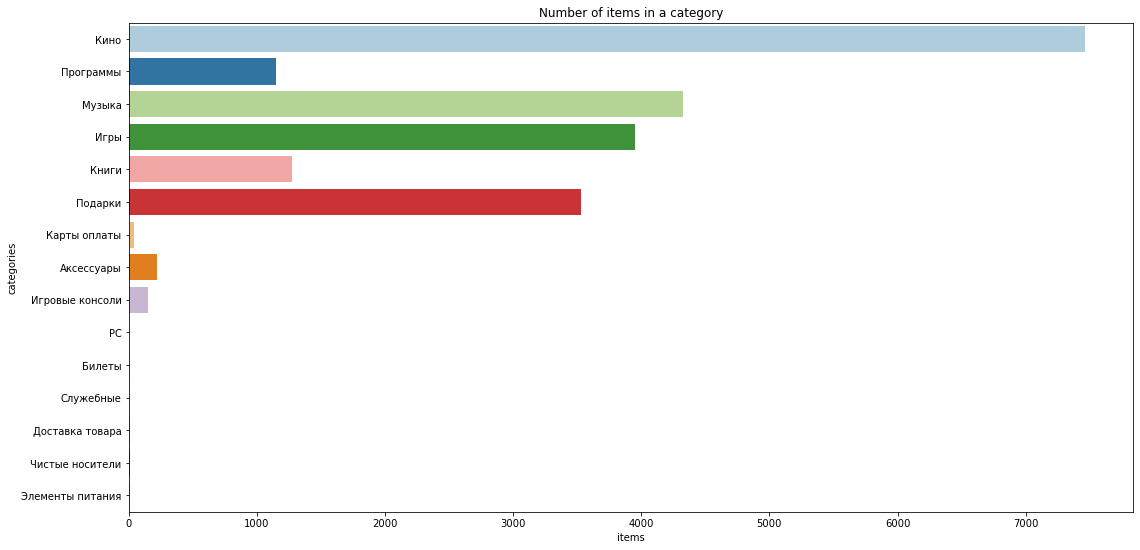

In [41]:
fig = plt.figure(figsize=(18,9))
chart = sns.countplot(y="cat", data=items_with_categories, palette = 'Paired')
chart.set(xlabel='items', ylabel='categories')
plt.title('Number of items in a category')
plt.show()

It looks like most items from items dataset are labeled as "Кино". Some categories are represented by a very limited amount of items. Maybe it would make sense to unite them into one category like 'other' for simplification later

# Sales

In [42]:
sales.sample(7)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2222411,14.12.2014,23,59,20949,4.8,5
1657076,18.05.2014,16,22,839,3000.0,1
855390,28.09.2013,8,19,16454,399.0,1
1910775,09.08.2014,19,17,16210,319.0,2
659734,02.07.2013,6,30,22140,499.0,1
1244439,29.12.2013,11,31,7201,199.0,1
1060268,10.11.2013,10,7,7213,899.0,1


In [43]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    int32  
dtypes: float64(1), int32(1), int64(3), object(1)
memory usage: 123.2+ MB


Let's change values in 'date' col from string to date type

In [44]:
sales.date = pd.to_datetime(sales.date, format='%d.%m.%Y')

In [45]:
sales.sample()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2022380,2014-09-30,20,54,14845,229.0,1


In [46]:
pd.unique(sales['date_block_num'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=int64)

In [47]:
sales.item_price.describe(percentiles=[.25, .5, .75, .95])

count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
95%      2.690000e+03
max      3.079800e+05
Name: item_price, dtype: float64

It looks like 95% of items were sold for less than 2690 RUB considering max price is ~300.000 RUB

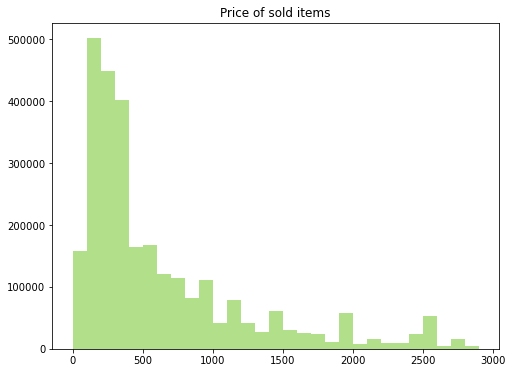

In [48]:
plt.figure(figsize=(8,6))
colors = sns.color_palette('Paired')[2]
plt.hist(sales.item_price, color = colors, bins = list(range(0,3000, 100)))
plt.title('Price of sold items')
plt.show()

In [49]:
sales.item_cnt_day.describe(percentiles=[.25, .5, .75, .875, .95])

count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
87.5%    1.000000e+00
95%      2.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

In [50]:
len(sales[sales.item_cnt_day > 1])/len(sales)

0.10188568962504543

It looks like most items were sold by <= 1 in a day and 95% were sold in less or equal than 2

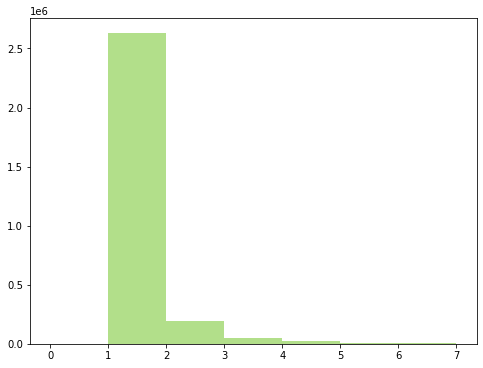

In [51]:
plt.figure(figsize=(8,6))
colors = sns.color_palette('Paired')[2]
plt.hist(sales.item_cnt_day, color = colors, bins = list(range(0,8, 1)))
plt.show()

Let's merge sales and shops dataset to see how the location affects the total amount of sold items

In [52]:
sales_shop = pd.merge(sales,shops, on = 'shop_id')

In [53]:
sales_shop.sample(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,city
2530708,2015-01-15,24,46,15063,449.0,1,"Сергиев Посад ТЦ ""7Я""",Сергиев
1842027,2013-06-21,5,54,20949,5.0,20,"Химки ТЦ ""Мега""",Химки
1903061,2014-05-01,16,54,13881,599.0,1,"Химки ТЦ ""Мега""",Химки
790540,2014-06-30,17,29,7736,299.0,1,"Москва ТЦ ""Новый век"" (Новокосино)",Москва
83562,2013-07-17,6,25,16178,239.0,2,"Москва ТРК ""Атриум""",Москва


# Outliers

C:\Users\charl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='item_price'>

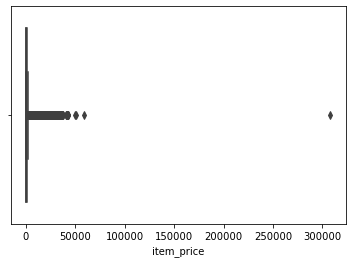

In [54]:
sns.boxplot(sales.item_price)

In [55]:
sales[sales.item_price >= 50000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
885138,2013-09-17,8,12,11365,59200.0,1
1163158,2013-12-13,11,12,6066,307980.0,1
1488135,2014-03-20,14,25,13199,50999.0,1


C:\Users\charl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='item_price'>

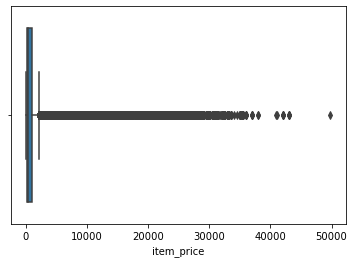

In [56]:
sns.boxplot(sales[sales.item_price <= 50000].item_price)

In [57]:
sales[sales.item_id == 6066 ]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,2013-12-13,11,12,6066,307980.0,1


C:\Users\charl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='item_cnt_day'>

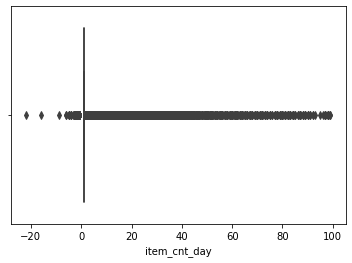

In [58]:
sns.boxplot(sales[sales.item_cnt_day < 100].item_cnt_day)

In [59]:
sales[sales.item_cnt_day > 100].groupby('date_block_num').groups.keys()

dict_keys([5, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 26, 27, 28, 31, 32, 33])

# Total sells in a city

In [60]:
cities_total = sales_shop.groupby('city')['item_cnt_day'].sum()

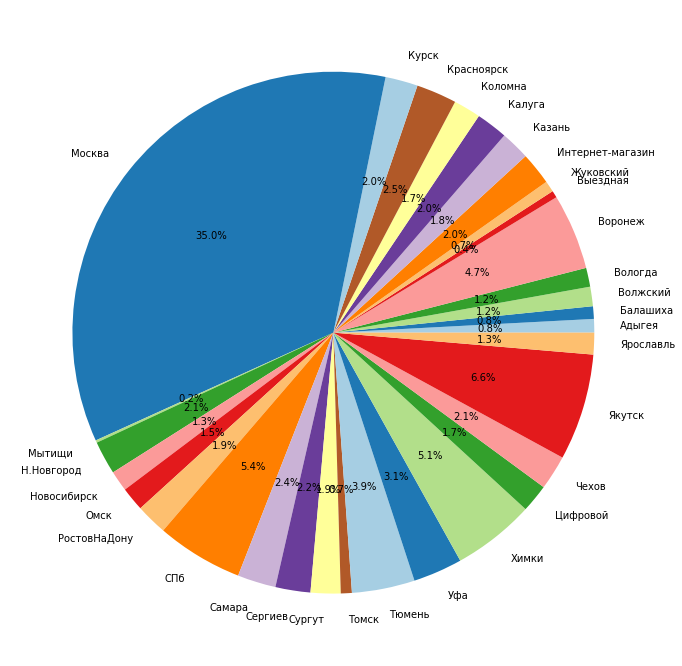

In [61]:
plt.figure(figsize=(12,12))
colors = sns.color_palette('Paired')[:len(cities_total)]
plt.pie(cities_total, labels = cities_total.index, autopct = '%0.1f%%', colors = colors)
plt.show()

As you can see from the pieplot Moscow is the leader. But Moscow also has much more shops than other cities. So let's take a look at the average count of items 

In [62]:
shops_count = pd.DataFrame(shops.groupby('city')['shop_name'].count()).reset_index(level = [0])

In [63]:
cities_total =  pd.DataFrame(cities_total).reset_index(level = [0])

In [64]:
cities_total = pd.merge(shops_count, cities_total, on = 'city')
cities_total.columns = ['city', 'shop_count', 'item_cnt_month']
cities_total['mean'] = cities_total.item_cnt_month/cities_total.shop_count
cities_total.head()

,city,shop_count,item_cnt_month,mean
0,Адыгея,1,30620,30620.000000
1,Балашиха,1,28355,28355.000000
2,Волжский,1,43942,43942.000000
3,Вологда,1,42762,42762.000000
4,Воронеж,3,171142,57047.333333


# Average amount of sold items in a city

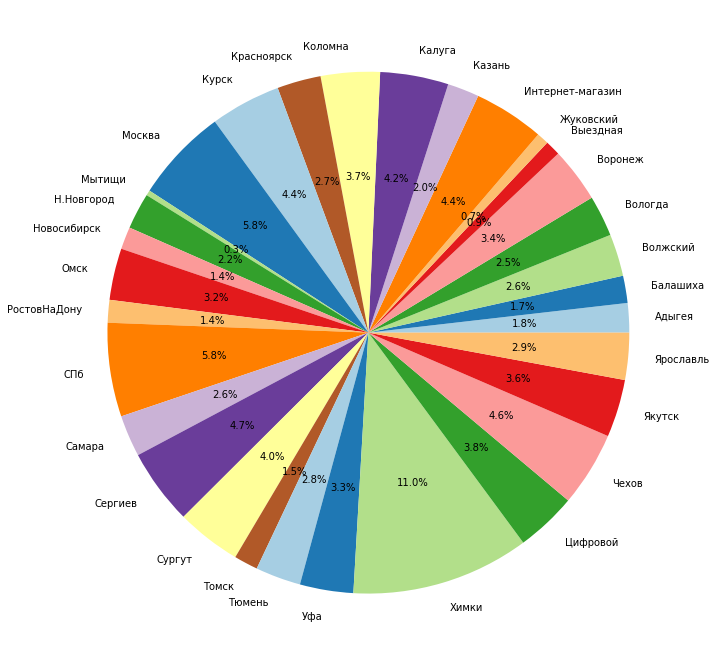

In [65]:
plt.figure(figsize=(12,12))
colors = sns.color_palette('Paired')[:len(cities_total)]
plt.pie(cities_total['mean'], labels = cities_total.city, autopct = '%0.1f%%', colors = colors)
plt.show()

From this pieplot Himky has more sold items in average. It has only one shop. 

Let's look at the amount of sold items per each shop

# Total sells in shops

In [66]:
shops_total = sales_shop.groupby('shop_name')['item_cnt_day'].sum()

In [67]:
sales.groupby('date_block_num').get_group(12).groupby('shop_id')['item_cnt_day'].sum()

shop_id
2       890
3       968
4      1430
5      1639
6      3024
7      2349
10      784
12     1103
13      960
14     1432
15     2460
16     1913
17     1436
18     2002
19     2596
21     1844
22     1522
24     2463
25     6835
26     1929
27     5451
28     6949
29     1981
30     2383
31    10017
35     1970
37     1125
38     1350
41     2055
42     3994
43     1625
44     1536
45     1367
46     2827
47     2153
49      676
50     3002
51     1623
52     1625
53     2144
54     8198
55     1150
56     2983
57     4962
58     2683
59     1491
Name: item_cnt_day, dtype: int32

In [101]:
# plt.figure(figsize=(12,12))
# colors = sns.color_palette('Paired')[:len(shops_total)]
# plt.pie(shops_total, labels = shops_total.index, autopct = '%0.1f%%', colors = colors)
# plt.show()

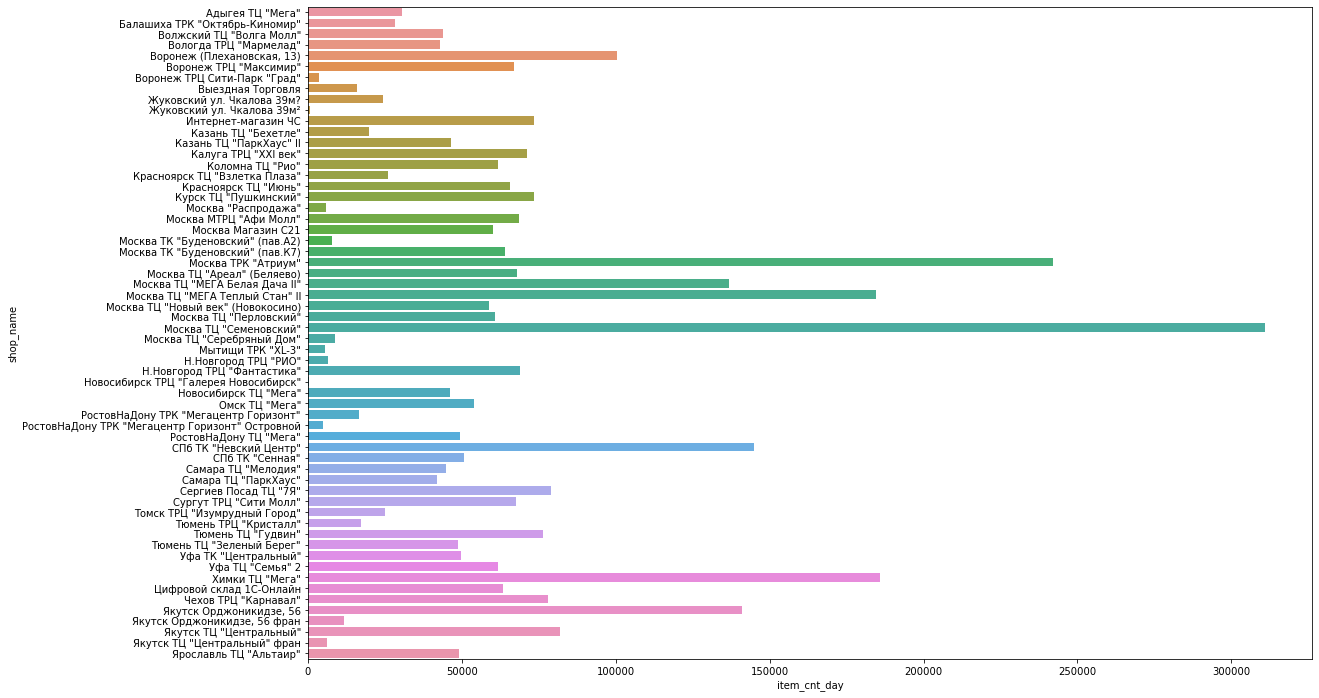

In [68]:
fig = plt.figure(figsize=(18,12))
chart = sns.barplot(x = shops_total, y = shops_total.index)
plt.show()

ADD CONCLUSION

We already saw the distribution of item_cnt_day.
Let's look at the distribution of sold items in a month

In [69]:
fet = pd.DataFrame(sales.groupby([sales.date_block_num, 'item_id'])['item_cnt_day'].sum())
fet.index.names = ['month', 'item_id']
fet.columns = ['item_cnt_month']
fet = fet.reset_index(level = [0,1])

In [70]:
fet.sample(3)

,month,item_id,item_cnt_month
21717,2,14443,16
156156,20,10253,9
145150,18,16085,17


In [71]:
fet[['item_cnt_month']].describe([.25, .5, .75, .95])

,item_cnt_month
count,233912.000000
mean,15.596489
std,96.125890
min,-22.000000
25%,2.000000
50%,4.000000
75%,11.000000
95%,54.000000
max,12557.000000


We see that 95% of the items are sold in less than 54 and the mode is 1

Let's look at the distribution

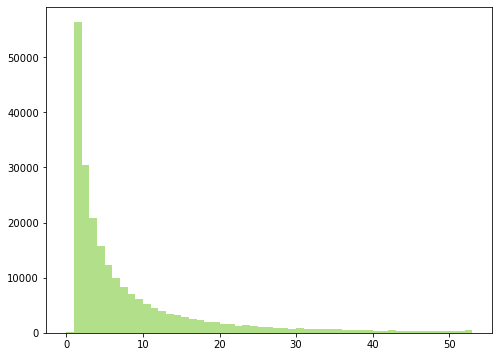

In [72]:
plt.figure(figsize=(8,6))
colors = sns.color_palette('Paired')[2]
plt.hist(fet.item_cnt_month, color = colors, bins = list(range(0,54, 1)))
plt.show()

# Which month is the most selling

In [73]:
m = [3,3,3,3,3,3,3,3,3,3,2,2]

In [74]:
mean_month = pd.DataFrame(sales.groupby(sales.date.dt.month)['item_cnt_day'].sum()/ m).reset_index(level = [0])

In [75]:
mean_month.columns = ['month', 'item_cnt_month']

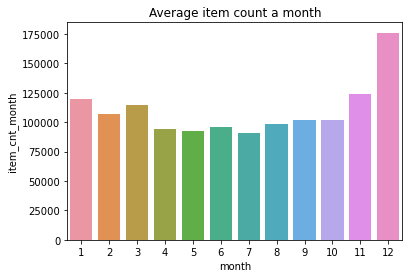

In [76]:
sns.barplot(x='month', y='item_cnt_month', data=mean_month)
plt.title('Average item count a month')
plt.show()

December is clearly the 'leader'

# Merge all

In [77]:
data = pd.merge(sales, shops, on = 'shop_id')
data = pd.merge(data, items, on = 'item_id')
data = pd.merge(data, categories, on = 'item_category_id' )

In [78]:
id_cols = ['shop_id', 'item_id', 'item_category_id']
num_cols = ['date_block_num', 'item_price', 'item_cnt_day']
cat_cols = ['city', 'cat']

In [79]:
data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,city,item_name,item_category_id,item_category_name,cat
0,2013-01-02,0,59,22154,999.0,1,"Ярославль ТЦ ""Альтаир""",Ярославль,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Кино
1,2013-01-02,0,25,22154,999.0,1,"Москва ТРК ""Атриум""",Москва,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Кино
2,2013-01-03,0,25,22154,999.0,1,"Москва ТРК ""Атриум""",Москва,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Кино
3,2013-01-20,0,25,22154,999.0,1,"Москва ТРК ""Атриум""",Москва,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Кино
4,2013-01-23,0,25,22154,999.0,1,"Москва ТРК ""Атриум""",Москва,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Кино


In [81]:
cat_total = data.groupby('cat')['item_cnt_day'].sum()

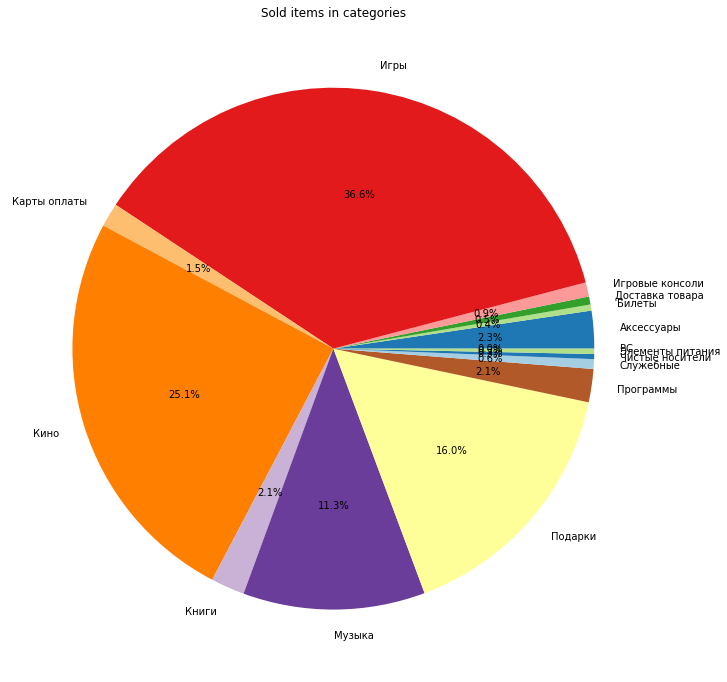

In [82]:
plt.figure(figsize=(12,12))
colors = sns.color_palette('Paired')[:len(cat_total)]
plt.pie(cat_total, labels = cat_total.index, autopct = '%0.1f%%', colors = colors)
plt.title('Sold items in categories')
plt.show()

In [83]:
cat_price = data.groupby('cat')['item_price'].describe()

In [84]:
cat_price = cat_price[['min','mean', 'max']]

In [85]:
categ = pd.unique(categories.cat)

In [86]:
cat_price = cat_price.reset_index(level=[0])

In [87]:
cat_price

,cat,min,mean,max
0,PC,22.400000,87.800000,148.0000
1,Аксессуары,22.000000,1962.820357,12490.0000
2,Билеты,600.000000,1345.441896,3507.8125
3,Доставка товара,0.908714,814.342848,59200.0000
4,Игровые консоли,8.000000,15475.282457,42990.0000
5,Игры,-1.000000,1120.791267,12999.0000
6,Карты оплаты,250.000000,1376.808853,3399.0000
7,Кино,0.200000,358.641213,7999.0000
8,Книги,17.000000,388.304958,3490.0000
9,Музыка,0.500000,364.583126,29999.0000


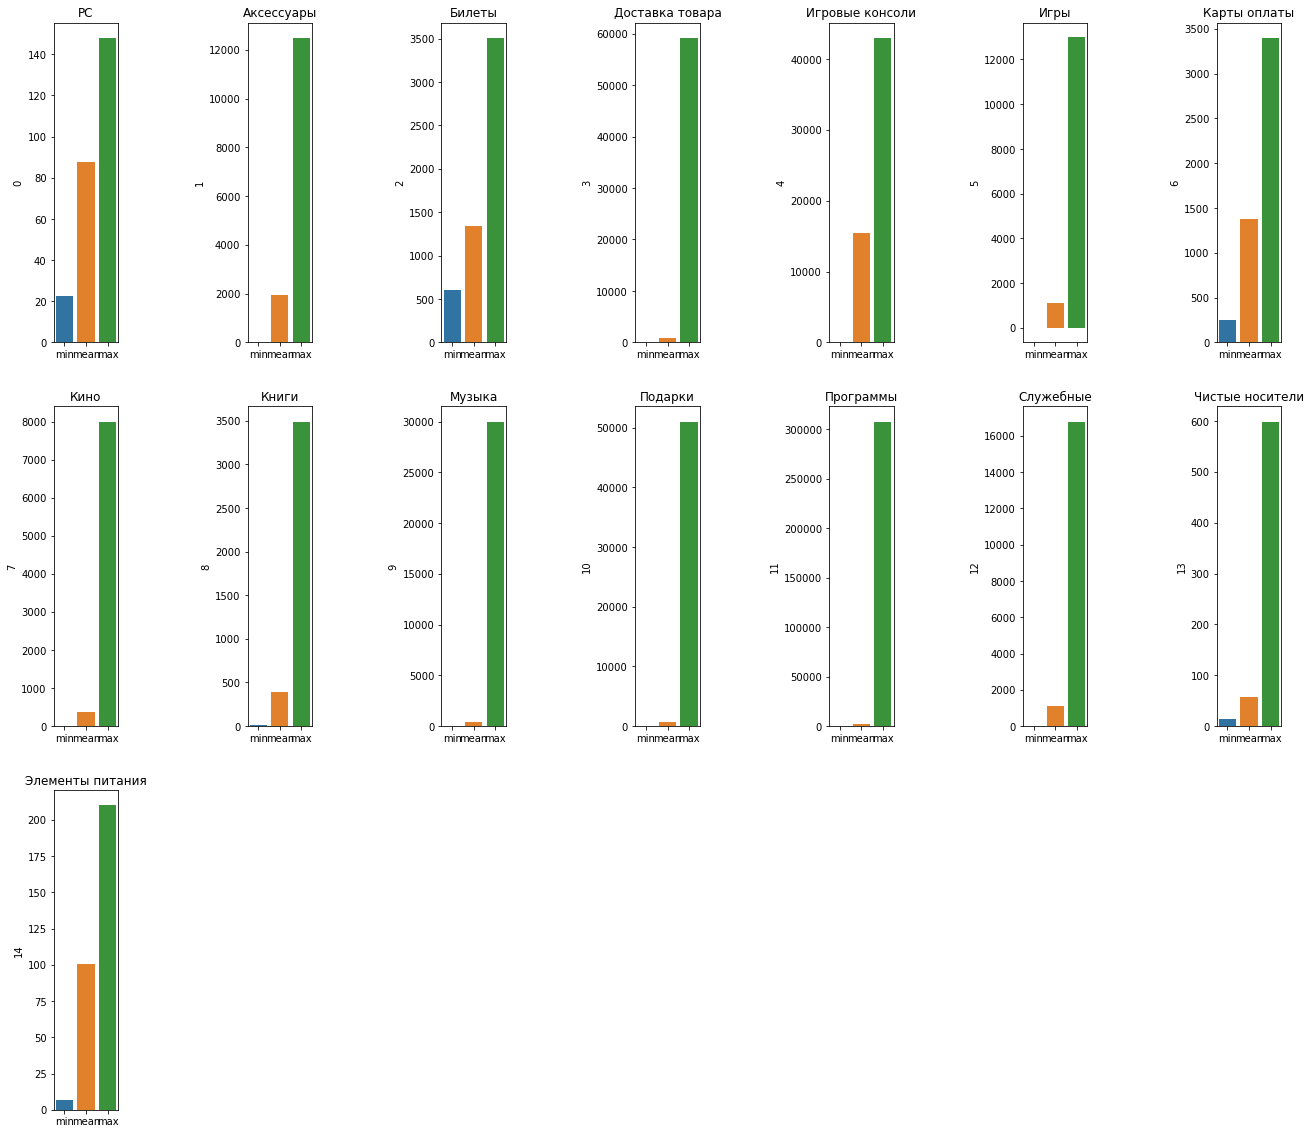

In [88]:
plt.figure(figsize=(22,20))
plt.subplots_adjust(wspace = 2)
for i in range(len(categ)):
    plt.subplot(3,len(categ)//2, i+1)
    sns.barplot(x = cat_price.columns[1:], y = cat_price.iloc[i,1:])
    plt.title(cat_price.iloc[i,0])
plt.show()


In [89]:
item_cnt = pd.DataFrame(data.groupby('item_id')['item_cnt_day'].sum()).reset_index(level = [0])
item_cnt.describe([.25, .5, .75, .95]).drop('item_id', axis = 1)

,item_cnt_day
count,21807.00000
mean,167.29518
std,1366.22019
min,-11.00000
25%,7.00000
50%,33.00000
75%,124.00000
95%,653.00000
max,187642.00000


In [90]:
item_price_mean = pd.DataFrame(data.groupby('item_id')['item_price'].mean()).reset_index(level = [0])

In [91]:
temp = pd.merge(item_cnt, item_price_mean, on = 'item_id')
temp.columns = ['item_id', 'item_cnt_total', 'item_price']
temp.head()

,item_id,item_cnt_total,item_price
0,0,1,58.0
1,1,6,4490.0
2,2,2,58.0
3,3,2,79.0
4,4,1,58.0


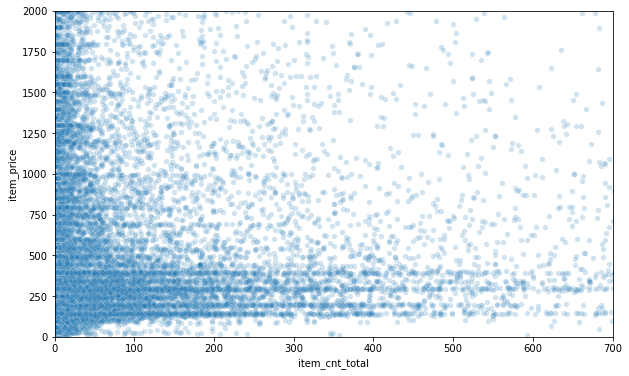

In [92]:
plt.figure(figsize=(10,6))
sc = sns.scatterplot(x = temp.item_cnt_total, y = temp.item_price, x_bins = [0, 50, 100], alpha = 0.2, s = 30)
sc.set_xlim(left=0, right=700)
sc.set_ylim(bottom=0, top=2000);

In [93]:
temp = data.groupby('date_block_num')['item_cnt_day'].sum()

In [94]:
temp.name = 'item_cnt_month'

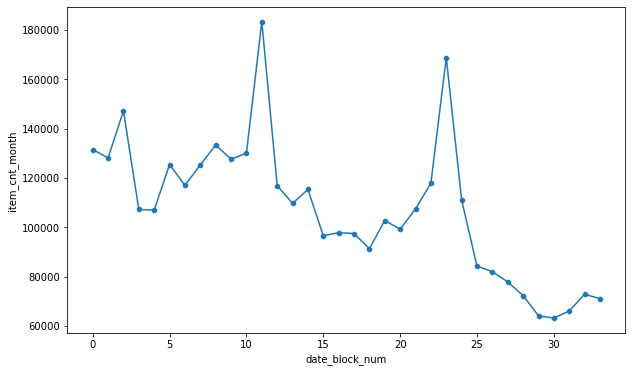

In [95]:
plt.figure(figsize=(10,6))
sns.scatterplot(y = temp,x = temp.index)
plt.plot(temp.index, temp)
plt.show()

In [ ]:
city_cnt_month = pd.DataFrame(data.groupby([data.date_block_num, 'city'])['item_cnt_day'].sum())

In [ ]:
city_cnt_month.columns = ['item_cnt_month']

In [ ]:
city_cnt_month

item_cnt_month
date_block_num city                     
0              Адыгея             1146.0
               Балашиха            767.0
               Волжский           2114.0
               Воронеж            7644.0
               Жуковский           935.0
...                                  ...
33             Уфа                1908.0
               Цифровой           1972.0
               Чехов              1263.0
               Якутск             3762.0
               Ярославль           790.0

[973 rows x 1 columns]

In [ ]:
city_cnt_month = city_cnt_month.reset_index(level=[0,1])

In [ ]:
city_cnt_month

,date_block_num,city,item_cnt_month
0,0,Адыгея,1146.0
1,0,Балашиха,767.0
2,0,Волжский,2114.0
3,0,Воронеж,7644.0
4,0,Жуковский,935.0
...,...,...,...
968,33,Уфа,1908.0
969,33,Цифровой,1972.0
970,33,Чехов,1263.0
971,33,Якутск,3762.0


# Dollar influence

In [96]:
price_time_mean = sales.groupby('date_block_num')['item_price'].mean()
price_time_median = sales.groupby('date_block_num')['item_price'].median()

In [97]:
def plot(a,b):
    plt.figure(figsize=(10,6))
    sns.scatterplot(y = a,x = a.index)
    plt.plot(a.index, a)
    sns.scatterplot(y = b,x =b.index)
    plt.plot(b.index, b)
    plt.show()

In [98]:
rub = pd.read_csv('D:/EPAM/epam_mentorship/data/rub.csv').reset_index(level=[0])

In [99]:
rub.rub = [float(x.split(' ')[0]) for x in rub.rub]

In [100]:
rub.columns=['date_block_num', 'rub']
price_time_mean = pd.DataFrame(price_time_mean).reset_index(level=[0])

In [101]:
price_time_median = pd.DataFrame(price_time_median).reset_index(level=[0])

In [103]:
temp = pd.merge(rub,price_time_mean, on = 'date_block_num')
temp.head()

,date_block_num,rub,item_price
0,0,30.2271,710.622127
1,1,30.1631,695.866856
2,2,30.8003,694.688063
3,3,31.3502,653.633797
4,4,31.3059,624.179993


In [104]:
temp.corr()

,date_block_num,rub,item_price
date_block_num,1.000000,0.882056,0.831244
rub,0.882056,1.000000,0.748266
item_price,0.831244,0.748266,1.000000


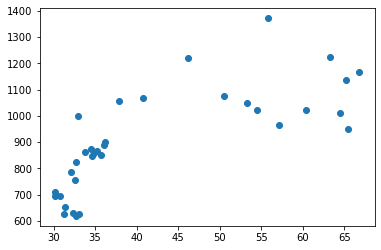

In [105]:
plt.scatter(rub.rub, price_time_mean.item_price)

In [106]:
data_month = pd.DataFrame(data.groupby('date_block_num')['item_cnt_day'].sum())

In [107]:
data_month.columns = ['item_cnt_month']
data_month = data_month.reset_index([0])


In [108]:
a = pd.merge(data_month, rub, on = 'date_block_num')
b = pd.merge(a, price_time_mean)

In [109]:
b.head()

,date_block_num,item_cnt_month,rub,item_price
0,0,131479,30.2271,710.622127
1,1,128090,30.1631,695.866856
2,2,147142,30.8003,694.688063
3,3,107190,31.3502,653.633797
4,4,106970,31.3059,624.179993


In [110]:
b.corr()

,date_block_num,item_cnt_month,rub,item_price
date_block_num,1.000000,-0.680142,0.882056,0.831244
item_cnt_month,-0.680142,1.000000,-0.575733,-0.237698
rub,0.882056,-0.575733,1.000000,0.748266
item_price,0.831244,-0.237698,0.748266,1.000000


# Mean price in categories through time

In [111]:
cat_time = pd.DataFrame(data.groupby(['cat','date_block_num'])['item_price'].mean()).reset_index(level=[0,1])

In [112]:
cat_time.head()

,cat,date_block_num,item_price
0,PC,0,148.000000
1,PC,1,93.000000
2,PC,3,22.400000
3,Аксессуары,0,1556.786779
4,Аксессуары,1,1622.352149


In [113]:
categ

array(['PC', 'Аксессуары', 'Билеты', 'Доставка товара', 'Игровые консоли',
       'Игры', 'Карты оплаты', 'Кино', 'Книги', 'Музыка', 'Подарки',
       'Программы', 'Служебные', 'Чистые носители', 'Элементы питания'],
      dtype=object)

In [114]:
m = pd.DataFrame({'date_block_num' : list(range(34))})

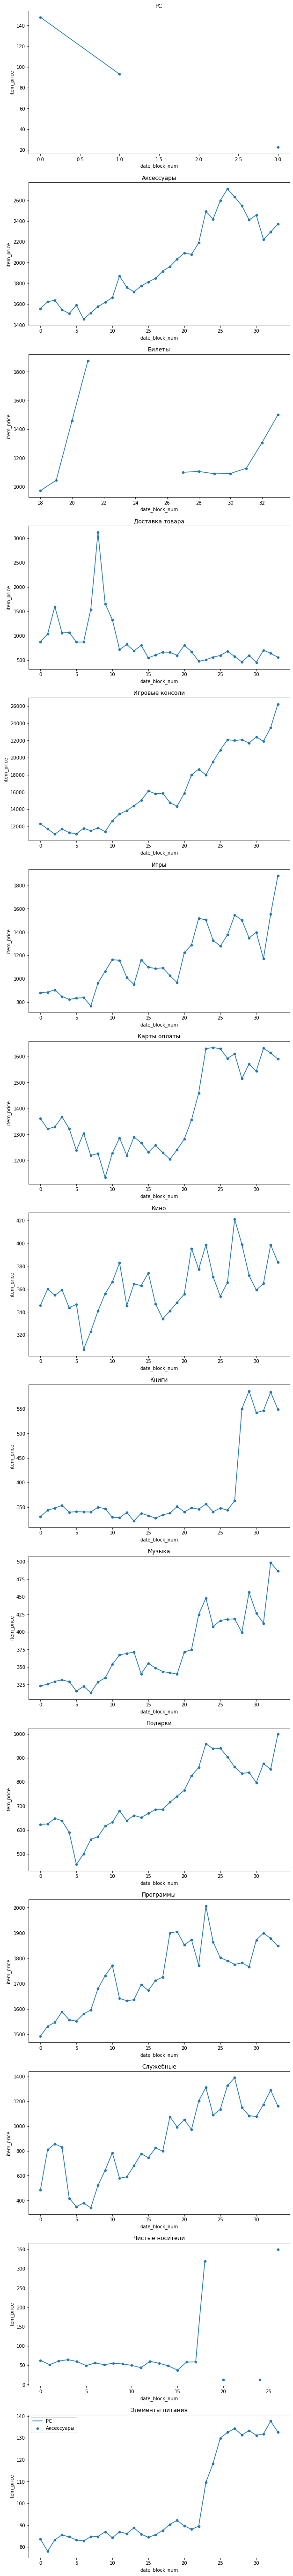

In [115]:
plt.figure(figsize=(10,100))
for i, c in enumerate(categ):
    t = cat_time[cat_time.cat == c]
    t = pd.merge(t,m, on = 'date_block_num', how = 'right')
    plt.subplot(len(categ),1, i+1)
    sns.scatterplot(x = t.date_block_num,y = t.item_price)
    plt.plot( t.date_block_num, t.item_price)
    plt.title(c)
plt.legend(categ)

In [116]:
cat_time = pd.DataFrame(data.groupby(['cat','date_block_num'])['item_cnt_day'].sum()).reset_index(level=[0,1])

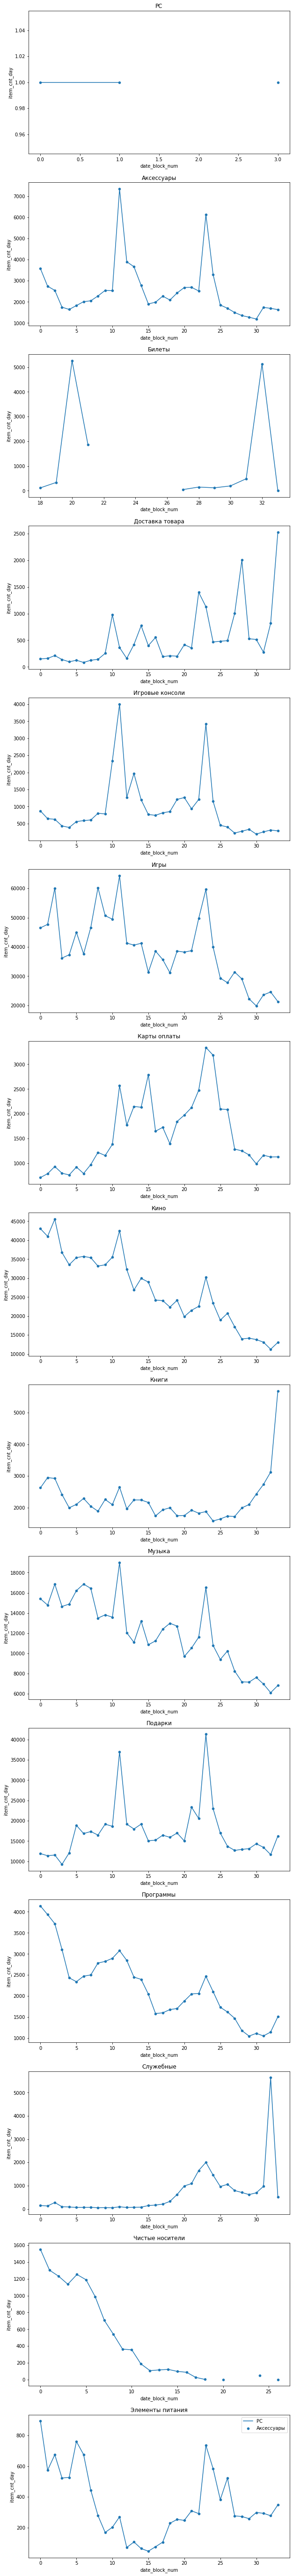

In [117]:
plt.figure(figsize=(10,100))
for i, c in enumerate(categ):
    t = cat_time[cat_time.cat == c]
    t = pd.merge(t,m, on = 'date_block_num', how = 'right')
    plt.subplot(len(categ),1, i+1)
    sns.scatterplot(x = t.date_block_num,y = t.item_cnt_day)
    plt.plot( t.date_block_num, t.item_cnt_day)
    plt.title(c)
plt.legend(categ)

In [118]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [119]:
add = pd.DataFrame({
    'date_block_num' : list(range(34))
})

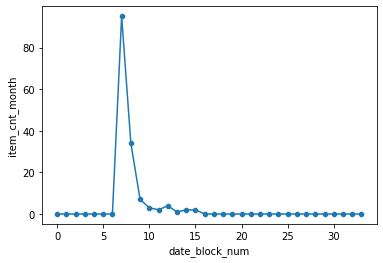

In [128]:
sample = data[data.item_id == items.sample().iloc[0,1]]

sample = pd.DataFrame(sample.groupby('date_block_num')['item_cnt_day'].sum()).reset_index([0])


a = pd.merge(sample,add, on = 'date_block_num', how = 'right').fillna(0)
a.columns = ['date_block_num', 'item_cnt_month']

sns.scatterplot(x = a.date_block_num,y = a.item_cnt_month)
plt.plot( a.date_block_num, a.item_cnt_month)

In [129]:
data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,city,item_name,item_category_id,item_category_name,cat
0,2013-01-02,0,59,22154,999.0,1,"Ярославль ТЦ ""Альтаир""",Ярославль,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Кино
1,2013-01-02,0,25,22154,999.0,1,"Москва ТРК ""Атриум""",Москва,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Кино
2,2013-01-03,0,25,22154,999.0,1,"Москва ТРК ""Атриум""",Москва,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Кино
3,2013-01-20,0,25,22154,999.0,1,"Москва ТРК ""Атриум""",Москва,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Кино
4,2013-01-23,0,25,22154,999.0,1,"Москва ТРК ""Атриум""",Москва,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Кино


In [130]:
data_item_month = pd.DataFrame(data.groupby(['item_id','date_block_num'])['item_cnt_day'].sum()).reset_index([0])
data_item_shop = pd.DataFrame(data.groupby(['item_id', 'shop_id','date_block_num'])['item_cnt_day'].sum()).reset_index([0,1])

In [131]:
it_ind = []
sh_ind = []
s = len(shops)
for i in items.item_id:
    it_ind += [i]*s
    sh_ind += list(range(s))
    

In [132]:
temp = pd.DataFrame({'item_id' : it_ind, 'shop_id': sh_ind})

In [133]:

for i in range(33):
    l = [i,i+1]
    sample = data_item_shop[data_item_shop.index.isin(l)]
    sample = sample.reset_index()

    data_32 = sample.groupby('date_block_num').get_group(l[0])
    data_33 = sample.groupby('date_block_num').get_group(l[1])
    data_32 = pd.merge(data_32, temp, how = 'right', on = ['item_id', 'shop_id']).fillna(0)
    data_33 = pd.merge(data_33, temp, how = 'right', on = ['item_id', 'shop_id']).fillna(0)
    a = pd.merge(data_32, data_33, on=['item_id', 'shop_id'], how='outer').drop(['date_block_num_x','item_id', 'shop_id', 'date_block_num_y' ], axis = 1)

    print(i, '-', i + 1)
    print(a.corr())
    print()

0 - 1
                item_cnt_day_x  item_cnt_day_y
item_cnt_day_x         1.00000         0.51235
item_cnt_day_y         0.51235         1.00000

1 - 2
                item_cnt_day_x  item_cnt_day_y
item_cnt_day_x        1.000000        0.394519
item_cnt_day_y        0.394519        1.000000

2 - 3
                item_cnt_day_x  item_cnt_day_y
item_cnt_day_x        1.000000        0.513122
item_cnt_day_y        0.513122        1.000000

3 - 4
                item_cnt_day_x  item_cnt_day_y
item_cnt_day_x        1.000000        0.374061
item_cnt_day_y        0.374061        1.000000

4 - 5
                item_cnt_day_x  item_cnt_day_y
item_cnt_day_x        1.000000        0.658381
item_cnt_day_y        0.658381        1.000000

5 - 6
                item_cnt_day_x  item_cnt_day_y
item_cnt_day_x         1.00000         0.87187
item_cnt_day_y         0.87187         1.00000

6 - 7
                item_cnt_day_x  item_cnt_day_y
item_cnt_day_x        1.000000        0.832982
item_cnt_day

In [134]:
indexes = pd.DataFrame({'item_id' : items.item_id})

In [135]:
for i in range(33):
    l = [i, i + 1]
    sample = data_item_month[data_item_month.index.isin(l)]
    sample = sample.reset_index()
    
    data_32 = sample.groupby('date_block_num').get_group(l[0])
    data_33 = sample.groupby('date_block_num').get_group(l[1])
    data_32 = pd.merge(data_32, indexes, how = 'right', on = 'item_id').fillna(0)
    data_33 = pd.merge(data_33, indexes, how = 'right', on = 'item_id').fillna(0)
    a = pd.merge(data_32, data_33, on='item_id', how='outer').drop(['date_block_num_x','item_id', 'date_block_num_y' ], axis = 1)
    print(i, '-', i + 1)
    print(a.corr())
    print()

0 - 1
                item_cnt_day_x  item_cnt_day_y
item_cnt_day_x        1.000000        0.591811
item_cnt_day_y        0.591811        1.000000

1 - 2
                item_cnt_day_x  item_cnt_day_y
item_cnt_day_x         1.00000         0.43509
item_cnt_day_y         0.43509         1.00000

2 - 3
                item_cnt_day_x  item_cnt_day_y
item_cnt_day_x        1.000000        0.596357
item_cnt_day_y        0.596357        1.000000

3 - 4
                item_cnt_day_x  item_cnt_day_y
item_cnt_day_x        1.000000        0.451542
item_cnt_day_y        0.451542        1.000000

4 - 5
                item_cnt_day_x  item_cnt_day_y
item_cnt_day_x        1.000000        0.768962
item_cnt_day_y        0.768962        1.000000

5 - 6
                item_cnt_day_x  item_cnt_day_y
item_cnt_day_x        1.000000        0.948739
item_cnt_day_y        0.948739        1.000000

6 - 7
                item_cnt_day_x  item_cnt_day_y
item_cnt_day_x        1.000000        0.901312
item_cnt_day

In [136]:
sales.dtypes

date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day               int32
dtype: object

In [137]:
first_date_shop = pd.DataFrame(sales.groupby('shop_id')['date'].min()).reset_index([0]).sort_values('date')

In [139]:
first_date_shop

,shop_id,date
14,14,2013-01-01
37,37,2013-01-01
38,38,2013-01-01
41,41,2013-01-01
19,19,2013-01-01
18,18,2013-01-01
42,42,2013-01-01
15,15,2013-01-01
27,27,2013-01-01
13,13,2013-01-01


In [138]:
pd.DataFrame(sales.groupby('shop_id')['date'].max()).reset_index([0]).sort_values('date')

,shop_id,date
0,0,2013-02-28
1,1,2013-02-28
8,8,2013-04-01
23,23,2013-04-28
32,32,2013-07-03
13,13,2014-08-09
17,17,2015-01-18
43,43,2015-01-25
40,40,2015-01-29
30,30,2015-02-18


In [19]:
pd.merge(first_date_shop, shops, on = 'shop_id', how = 'outer')

,shop_id,date,shop_name,city
0,14,2013-01-01,"Казань ТЦ ""ПаркХаус"" II",Казань
1,37,2013-01-01,"Новосибирск ТЦ ""Мега""",Новосибирск
2,38,2013-01-01,"Омск ТЦ ""Мега""",Омск
3,41,2013-01-01,"РостовНаДону ТЦ ""Мега""",РостовНаДону
4,19,2013-01-01,"Курск ТЦ ""Пушкинский""",Курск
5,18,2013-01-01,"Красноярск ТЦ ""Июнь""",Красноярск
6,42,2013-01-01,"СПб ТК ""Невский Центр""",СПб
7,15,2013-01-01,"Калуга ТРЦ ""XXI век""",Калуга
8,27,2013-01-01,"Москва ТЦ ""МЕГА Белая Дача II""",Москва
9,13,2013-01-01,"Казань ТЦ ""Бехетле""",Казань
